In [89]:
import os
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.preprocess import remove_urls, strip_html
from reviews.config import processed_data_dir
from reviews.utils import clean_brand

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Data Cleaning

## Products

In [90]:
prod_df = pd.read_json(processed_data_dir / "meta.json.gz")
prod_df = prod_df.reindex(sorted(prod_df.columns), axis=1)  # sort columns
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   asin             32720 non-null  object
 1   brand            32720 non-null  object
 2   category         32720 non-null  object
 3   description      32720 non-null  object
 4   imageURLHighRes  32720 non-null  object
 5   price            32720 non-null  object
 6   title            32720 non-null  object
dtypes: object(7)
memory usage: 1.7+ MB


In [91]:
prod_df.head(10)

,asin,brand,category,description,imageURLHighRes,price,title
0,7500653883,ECS Elitegroup,"[Electronics, Computers & Accessories, Compute...",[],[],,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,MyGica,"[Electronics, Computers & Accessories, Compute...","[Mygica EZgrabber2 USB 2.0 Video Capture, VHS ...",[https://images-na.ssl-images-amazon.com/image...,,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,Creative,"[Electronics, Computers & Accessories, Compute...",[],[],,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,APC,"[Electronics, Computers & Accessories, Compute...",[APC 650 VA Uninterruptable Power Supply],[],,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],[],,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,Creative,"[Electronics, Computers & Accessories, Compute...",[Based on the award-winning Sound Blaster 16 t...,[],$2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],[],,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,Diamond,"[Electronics, Computers & Accessories, Compute...",[Monster Sound MX300 is the new-generation PCI...,[],,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,SONICblue,"[Electronics, Computers & Accessories, Compute...","[Based on the NVIDIA RIVA TNT Ultra chip set, ...",[https://images-na.ssl-images-amazon.com/image...,,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,PNY,"[Electronics, Computers & Accessories, Compute...",[Adding memory to your new or existing desktop...,[],,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Transform Data

In [92]:
# keep the first subcategory and rename categories
prod_df["category"] = prod_df["category"].parallel_apply(
    lambda x: x[4] if len(x) > 4 else "other"
)

prod_df["category"] = prod_df["category"].apply(
    lambda cat: cat.replace("Internal", "").strip() if type(cat) is str else cat
)

# join description in a single string
prod_df["description"] = prod_df["description"].parallel_apply(lambda x: " ".join(x))

# remove html and replace empty with NA
for col in ["category", "description", "title", "brand", "asin"]:
    prod_df[col] = prod_df[col].astype("string").parallel_apply(strip_html)
    prod_df.loc[prod_df[col] == "", col] = np.nan

# fix price
prod_df["price"] = prod_df["price"].astype("string").parallel_apply(strip_html)
prod_df["price"] = prod_df["price"].str.replace("[\$,]", "", regex=True)
prod_df.loc[prod_df["price"].str.len() == 0, "price"] = np.nan
prod_df.loc[prod_df["price"].str.len() > 20, "price"] = np.nan

prod_df["brand"] = prod_df["brand"].apply(clean_brand)

prod_df["imageURLHighRes"] = prod_df["imageURLHighRes"].parallel_apply(
    lambda x: x[0] if x else np.nan
)

In [93]:
prod_df.head(10)

,asin,brand,category,description,imageURLHighRes,price,title
0,7500653883,ecs elitegroup,Motherboards,NaN,NaN,NaN,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,mygica,TV Tuner & Capture Cards,"Mygica EZgrabber2 USB 2.0 Video Capture, VHS t...",https://images-na.ssl-images-amazon.com/images...,NaN,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,creative,Modems,NaN,NaN,NaN,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,apc,Power Supplies,APC 650 VA Uninterruptable Power Supply,NaN,NaN,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,creative,Graphics Cards,Unleash incredible graphics performance!,NaN,NaN,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,creative,Sound Cards,Based on the award-winning Sound Blaster 16 te...,NaN,2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,creative,Graphics Cards,Unleash incredible graphics performance!,NaN,NaN,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,diamond,Graphics Cards,Monster Sound MX300 is the new-generation PCI ...,NaN,NaN,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,sonicblue,Graphics Cards,"Based on the NVIDIA RIVA TNT Ultra chip set, D...",https://images-na.ssl-images-amazon.com/images...,NaN,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,pny,Memory,Adding memory to your new or existing desktop ...,NaN,NaN,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Convert Data Types

In [94]:
prod_df["asin"] = prod_df["asin"].astype("string")
prod_df["brand"] = prod_df["brand"].astype("category")
prod_df["category"] = prod_df["category"].astype("category")
prod_df["description"] = prod_df["description"].astype("string")
prod_df["price"] = prod_df["price"].astype("float")
prod_df["title"] = prod_df["title"].astype("string")
prod_df["imageURLHighRes"] = prod_df["imageURLHighRes"].astype("string")

## Reviews

In [95]:
review_df = pd.read_json(processed_data_dir / "reviews.json.gz")
review_df = review_df.reindex(sorted(review_df.columns), axis=1)  # sort columns
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       269027 non-null  object        
 1   overall    269027 non-null  int64         
 2   summary    269027 non-null  object        
 3   text       269027 non-null  object        
 4   timestamp  269027 non-null  datetime64[ns]
 5   vote       269027 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 12.3+ MB


In [96]:
review_df.head(10)

,asin,overall,summary,text,timestamp,vote
0,7799813393,3,Good for what it can do.,Bought this to transfer video from some old eq...,2013-01-17,0
1,7799813393,4,works well,The EZGrabber2 works well but it's software is...,2012-09-04,0
2,7799813393,4,Cheap and it works,I got this because it was pretty decently pric...,2012-08-27,6
3,B00000J579,5,"Easy to Use, Almost everything you could want",This sound card doesn't reproduce MP3 or WAV f...,2000-10-10,32
4,B00000J579,3,Bathtub,"Essentially, this is the entry-level, 16-bit a...",2000-09-04,4
5,B00000J579,4,"Good low-end, no-hassle card",This is a basic sound card. Nothing fancy. T...,2002-07-03,6
6,B00000J579,3,Ok for the price and basic functions,This is a basic low-end sound card. It puts ou...,2002-04-04,8
7,B00000JDKU,4,good card,The Voodoo 3 is a great card that replaces bot...,1999-11-21,18
8,B00000JDKU,5,WOW!,This card is so fast and really high resolutio...,1999-07-15,4
9,B00000JF4L,5,An excellent card,Let me first state that I purchased this card ...,2000-03-15,38


In [97]:
# remove html and replace empty with NA
for col in ["asin", "overall", "summary", "text", "timestamp", "vote"]:
    review_df[col] = review_df[col].astype("string").parallel_apply(strip_html)
    review_df.loc[review_df[col] == "", col] = np.nan

### Convert Data Types

In [98]:
review_df["asin"] = review_df["asin"].astype("category")
review_df["overall"] = review_df["overall"].astype("category")
review_df["summary"] = review_df["summary"].astype("string")
review_df["text"] = review_df["text"].astype("string")
review_df["timestamp"] = pd.to_datetime(review_df["timestamp"], errors="coerce")
review_df["vote"] = review_df["vote"].astype("int")

In [99]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       269027 non-null  category      
 1   overall    269027 non-null  category      
 2   summary    269027 non-null  string        
 3   text       269025 non-null  string        
 4   timestamp  269027 non-null  datetime64[ns]
 5   vote       269027 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(1), string(2)
memory usage: 9.3 MB


### Merge with Products

In [100]:
data_df = pd.merge(left=review_df, right=prod_df, on="asin", copy=False)
data_df = data_df.sample(25000, random_state=1111)

data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["asin"] = data_df["asin"].astype("string").astype("category")
data_df["overall"] = data_df["overall"].astype("string").astype("category")
data_df["brand"] = data_df["brand"].astype("string").astype("category")
data_df["category"] = data_df["category"].astype("string").astype("category")

In [101]:
duplicates = data_df.duplicated(["asin", "text", "summary", "overall"], keep=False)
print(f"Duplicates: {duplicates.sum()}")

data_df.drop_duplicates(["asin", "text", "summary", "overall"], inplace=True)

Duplicates: 52


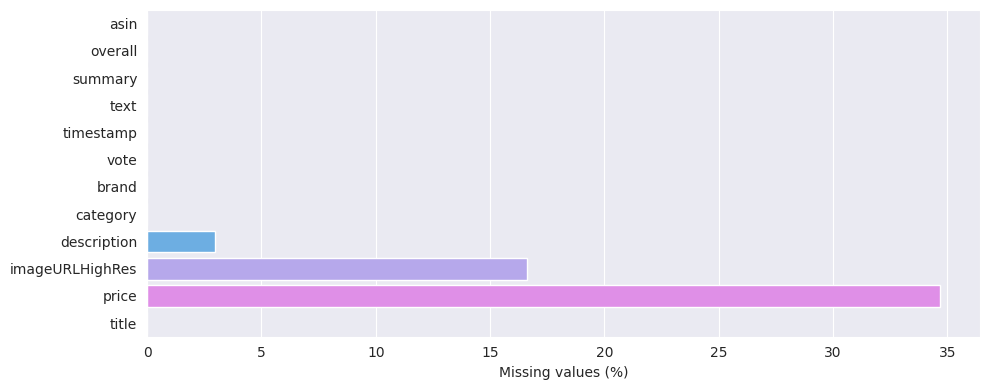

In [102]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
#sns.heatmap(data_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=data_df.columns,
    x=(len(data_df) - data_df.count()) / len(data_df) * 100,
    ax=axes
)
axes.set_xlabel("Missing values (%)")
fig.tight_layout()

In [103]:
# remove empty text
data_df = data_df.loc[~data_df["text"].isna()]

### Language Identification

In [104]:
if not os.path.exists("/tmp/lid.176.bin"):
    os.system(
        "wget -O /tmp/lid.176.bin 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'"
    )

In [105]:
model = fasttext.load_model("/tmp/lid.176.bin")

langs = []
probs = []
for i, row in data_df.iterrows():
    text = row["text"]

    text = text.replace("\n", " ")

    text = remove_urls(text)
    text = strip_html(text)

    text = text.lower()

    lang = model.predict(text, threshold=0.65)

    if len(lang[0]) > 0:
        prob = lang[1][0]
        lang = lang[0][0].replace("__label__", "")

        if lang != "en":
            lang = "others"

        langs.append(lang)
        probs.append(prob)
    else:
        langs.append("others")
        probs.append(0)


data_df.insert(loc=0, column="lang", value=langs)
data_df.insert(loc=0, column="prob", value=probs)

data_df["lang"].value_counts()

en        24054
others      919
Name: lang, dtype: int64

In [106]:
data_df[data_df["lang"] == "others"].sort_values("prob", ascending=False)

,prob,lang,asin,overall,summary,text,timestamp,vote,brand,category,description,imageURLHighRes,price,title
51090,1.000046,others,B0030ZDNSI,5,Five Stars,Muy bien,2014-11-19,0,hynix infineon samsung top ten manufacturers,Memory,<NA>,<NA>,12.95,2GB Memory RAM Upgrade for the Dell Inspiron 1...
54735,1.000045,others,B003BFNYK4,4,Four Stars,muy buenas,2014-12-04,0,asrock,Motherboards,ASRock LAG 775 G41/2DR3/2DRR2/8G/MATX Motherbo...,<NA>,NaN,ASRock G41C-GS LGA 775 G41 DDR2+DRR3 8GB Micro...
240869,1.000045,others,B012TS9UOM,4,Four Stars,muy buenas,2016-07-04,0,pny,Memory,PNY Performance 8GB Kit (2x4GB) DDR3 1600MHz (...,https://images-na.ssl-images-amazon.com/images...,NaN,PNY Performance 8GB Kit DDR3 1600MHz CL11 1.35...
87884,1.000045,others,B005JRH9V2,5,Five Stars,Muy buenas,2017-10-02,0,corsair,Memory,Shipping Height: 0.1 Shipping Width: 5.0 Maste...,https://images-na.ssl-images-amazon.com/images...,3.89,Corsair CMSA8GX3M2A1333C9 Apple Certified 8GB ...
149471,1.000045,others,B00C537BQ6,5,Five Stars,MUY BUENAS,2015-02-13,0,a-tech components,Memory,2GB kit (1GBx2) DDR2 PC2-6400 DESKTOP Memory M...,<NA>,10.45,2GB kit (1GBx2) DDR2 PC2-6400 DESKTOP Memory M...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204702,0.000000,others,B00KPRWAX8,5,Five Stars,Excellent.,2015-08-23,0,intel,CPU Processors,Intel Core BX80646I74790K i7-4790K Processor (...,https://images-na.ssl-images-amazon.com/images...,7.47,Intel Core i7-4790K Processor- BX80646I74790K
144452,0.000000,others,B00B4BJY7E,5,excelente,excelente,2017-10-08,0,intel,CPU Processors,Intel Corporation Intel Celeron G1620 2.70 GHz...,<NA>,59.99,2QW2873 - Intel Celeron G1620 2.70 GHz Process...
251727,0.000000,others,B01AZHOWL0,5,best thing i ever bought per dollar or at all,$46 - made my PC 3x stronger. 2 gb ram adds to...,2018-08-19,0,msi,Graphics Cards,"MSI GT 710 1GD3H LP: NVIDIA GeForce GT 710, 1G...",https://images-na.ssl-images-amazon.com/images...,2.54,MSI Gaming GeForce GT 710 1GB GDRR3 64-bit HDC...
229093,0.000000,others,B00UN7AWIK,5,Five Stars,Best motherboard I've used!,2015-09-18,0,msi,Motherboards,"MSI X99A GAMING 7: Socket LGA 2011-3, Intel X9...",https://images-na.ssl-images-amazon.com/images...,NaN,MSI Extreme Gaming Intel X99 LGA 2011 DDR4 USB...


In [107]:
# keep only english reviews
data_df = data_df.loc[data_df["lang"] == "en"]
data_df.drop(columns=["lang", "prob"], axis=1, inplace=True)

In [108]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24054 entries, 150394 to 96130
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             24054 non-null  category      
 1   overall          24054 non-null  category      
 2   summary          24054 non-null  string        
 3   text             24054 non-null  string        
 4   timestamp        24054 non-null  datetime64[ns]
 5   vote             24054 non-null  int64         
 6   brand            24054 non-null  category      
 7   category         24054 non-null  category      
 8   description      23341 non-null  string        
 9   imageURLHighRes  20064 non-null  string        
 10  price            15659 non-null  float64       
 11  title            24054 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), string(5)
memory usage: 2.0 MB


#### Save

In [109]:
data_df["asin"] = data_df["asin"].astype("string").astype("category")
data_df["overall"] = data_df["overall"].astype("string").astype("category")
data_df["brand"] = data_df["brand"].astype("string").astype("category")
data_df["category"] = data_df["category"].astype("string").astype("category")

data_df.reset_index(drop=True, inplace=True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24054 entries, 0 to 24053
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             24054 non-null  category      
 1   overall          24054 non-null  category      
 2   summary          24054 non-null  string        
 3   text             24054 non-null  string        
 4   timestamp        24054 non-null  datetime64[ns]
 5   vote             24054 non-null  int64         
 6   brand            24054 non-null  category      
 7   category         24054 non-null  category      
 8   description      23341 non-null  string        
 9   imageURLHighRes  20064 non-null  string        
 10  price            15659 non-null  float64       
 11  title            24054 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), string(5)
memory usage: 1.8 MB


In [110]:
data_df.to_json(processed_data_dir / "products_reviews.json.gz")